<a href="https://colab.research.google.com/github/AntonDozhdikov/RL_OTUS_Learn/blob/main/Lunar_V3_DDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# @title установка драйверов
# Команда apt-get update обновляет индекс пакетов, чтобы получить последнюю информацию о доступных версиях пакетов.
!apt-get update > /dev/null 2>&1

# Установка необходимых пакетов: xvfb (виртуальный фреймбуфер X), Python OpenGL и ffmpeg (для обработки видео).
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

# Установка пакетов для разработки на C/C++ и Python: swig (интерфейс между языками программирования), build-essential (инструменты сборки), python-dev и python3-dev (заголовочные файлы и библиотеки для Python).
!apt-get install -y swig build-essential python-dev python3-dev > /dev/null 2>&1

# Установка утилит для работы с X-сервером, таких как xrandr и xdpyinfo.
!apt-get install x11-utils > /dev/null 2>&1

# Установка виртуального фреймбуфера X (xvfb), который позволяет запускать графические приложения без физического дисплея.
!apt-get install xvfb > /dev/null 2>&1

In [14]:
# @title установка библиотек
#%%capture
# Устанавливает библиотеку rarfile для работы с архивами RAR.
!pip install rarfile --quiet

# Устанавливает пакет stable-baselines3 с дополнительными зависимостями.
!pip install stable-baselines3[extra] --quiet

# Устанавливает библиотеку Ale-Py для работы с Atari играми.
!pip install ale-py --quiet

# Устанавливает пакет gym с поддержкой Box2D для физических симуляций.
!pip install gym[box2d] --quiet

# Устанавливает PyVirtualDisplay для создания виртуальных дисплеев. Страшно кривая вещь!!! Ни в колабе ни на машине не работает
!pip install pyvirtualdisplay --quiet

# Устанавливает Pyglet для работы с графикой и мультимедиа.
!pip install pyglet --quiet

# Устанавливает PyGame для разработки игр.
!pip install pygame --quick

# Устанавливает Minigrid для создания простых gridworld сред.
!pip install minigrid --quiet

# Устанавливает SWIG для взаимодействия между различными языками программирования.
!pip install -q swig --quiet

# Устанавливает Gymnasium с поддержкой Box2D для физических симуляций.
!pip install -q gymnasium[box2d] --quiet

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --quick


In [15]:
# Импортируем библиотеку gymnasium для работы с окружениями
import gymnasium as gym

# Импортируем библиотеку NumPy для работы с массивами
import numpy as np

# Импортируем библиотеку PyTorch для работы с нейронными сетями
import torch

# Импортируем модуль nn из библиотеки PyTorch для создания нейронных сетей
import torch.nn as nn

# Импортируем модуль optim из библиотеки PyTorch для оптимизации параметров модели
import torch.optim as optim

# Импортируем модуль functional из библиотеки PyTorch для различных функций активации
import torch.nn.functional as F

# Импортируем классы deque и namedtuple из модуля collections
from collections import deque, namedtuple

# Импортируем модуль random для генерации случайных чисел
import random

In [16]:
# Создаем именованный кортеж Experience с полями: state, action, reward, next_state и done для опыта
Experience = namedtuple('Experience',
                        ('state', 'action', 'reward', 'next_state', 'done'))

In [17]:
# Класс ReplayBuffer для реализации буфера воспроизведения
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        # Инициализация очереди с максимальной длиной buffer_size
        self.buffer = deque(maxlen=buffer_size)
        # Сохранение размера батча
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        # Добавление нового опыта в очередь
        self.buffer.append(Experience(state, action, reward, next_state, done))

    def sample(self):
        # Выбор случайной выборки из буфера размером batch_size
        experiences = random.sample(self.buffer, k=self.batch_size)

        # Преобразование состояний в тензоры
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float()
        # Преобразование действий в тензоры
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long()
        # Преобразование вознаграждений в тензоры
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float()
        # Преобразование следующих состояний в тензоры
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float()
        # Преобразование признаков завершения в тензоры
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float()

        # Возвращаем кортеж из всех преобразованных элементов
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        # Возвращаем текущую длину буфера
        return len(self.buffer)


In [18]:
# Определение нейронной сети
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        # Наследуемся от базового класса nn.Module и вызываем его конструктор
        super(QNetwork, self).__init__()
        # Устанавливаем начальное значение генератора случайных чисел
        self.seed = torch.manual_seed(seed)
        # Первый линейный слой, принимающий входное состояние и выдающий 128 нейронов
        self.fc1 = nn.Linear(state_size, 128)
        # Второй линейный слой, принимающий 128 нейронов и выдающий 128 нейронов
        self.fc2 = nn.Linear(128, 128)
        # Третий линейный слой, принимающий 128 нейронов и выдающий количество возможных действий
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        # Применяем первую линейную трансформацию и активацию ReLU
        x = F.relu(self.fc1(state))
        # Применяем вторую линейную трансформацию и активацию ReLU
        x = F.relu(self.fc2(x))
        # Применяем третью линейную трансформацию без активации
        return self.fc3(x)

In [19]:
# Определение класса агента DDQN
class DDQNAgent:
    def __init__(self, state_size, action_size, seed,
                 buffer_size=int(1e5), batch_size=64,
                 gamma=0.99, tau=1e-3, lr=1e-4, update_every=4):
        # Инициализация параметров агента
        self.state_size = state_size        # Размерность пространства состояний
        self.action_size = action_size      # Размерность пространства действий
        self.batch_size = batch_size        # Размер батча для обучения
        self.gamma = gamma                  # Коэффициент дисконтирования
        self.tau = tau                      # Скорость мягкого обновления целевой сети
        self.update_every = update_every    # Частота обновления сети
        self.t_step = 0                     # Счетчик шагов для обновления

        # Инициализация Q-сетей (основная и целевая)
        self.main_net = QNetwork(state_size, action_size, seed)    # Основная сеть для выбора действий
        self.target_net = QNetwork(state_size, action_size, seed)  # Целевая сеть для оценки
        self.optimizer = optim.Adam(self.main_net.parameters(), lr=lr)  # Оптимизатор

        # Инициализация буфера воспроизведения
        self.memory = ReplayBuffer(buffer_size, batch_size)  # Хранилище опыта

    def step(self, state, action, reward, next_state, done):
        # Добавление опыта в буфер
        self.memory.add(state, action, reward, next_state, done)

        # Обучение с заданной периодичностью
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # Запуск обучения при достаточном количестве данных
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()  # Выборка батча из памяти
                self.learn(experiences)            # Обновление сетей

    def act(self, state, eps=0.):
        # Выбор действия (epsilon-жадная стратегия)
        state = torch.from_numpy(state).float().unsqueeze(0)  # Конвертация в тензор
        self.main_net.eval()                                 # Переключение в режим оценки
        with torch.no_grad():
            action_values = self.main_net(state)             # Получение Q-значений
        self.main_net.train()                               # Возврат в режим обучения

        # Выбор действия: жадно или случайно
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())  # Жадное действие
        else:
            return random.choice(np.arange(self.action_size))   # Случайное действие

    def learn(self, experiences):
        # Извлечение данных из батча
        states, actions, rewards, next_states, dones = experiences

        # Вычисление целевых Q-значений (DDQN логика)
        Q_targets_next = self.target_net(next_states).detach()   # Q-значения от целевой сети
        Q_main_next = self.main_net(next_states).detach()  # Q-значения от основной сети
        max_actions = Q_main_next.argmax(1, keepdim=True)   # Выбор лучших действий основной сетью

        # Расчет целевых значений с учетом награды и дисконтирования
        Q_targets = rewards + (self.gamma * Q_targets_next.gather(1, max_actions) * (1 - dones))

        # Получение текущих Q-значений
        Q_expected = self.main_net(states).gather(1, actions)  # Q-значения для выбранных действий

        # Расчет и минимизация потерь
        loss = F.mse_loss(Q_expected, Q_targets) # MSE loss
        self.optimizer.zero_grad()  # Обнуление градиентов
        loss.backward()    # Обратное распространение
        self.optimizer.step()    # Обновление весов

        # Мягкое обновление целевой сети
        self.soft_update()

    def soft_update(self):
        # Постепенное обновление параметров целевой сети
        for target_param, main_param in zip(self.target_net.parameters(), self.main_net.parameters()):
            target_param.data.copy_(self.tau * main_param.data + (1.0 - self.tau) * target_param.data)

In [20]:
# Петля обучения
env = gym.make('LunarLander-v3')  # Создаем среду LunarLander-v3 из библиотеки OpenAI Gym

state_size = env.observation_space.shape[0]  # Определяем размерность пространства состояний
action_size = env.action_space.n  # Определяем количество возможных действий

agent = DDQNAgent(state_size=state_size, action_size=action_size, seed=0)  # Создаем агента Double DQN с заданными параметрами

n_episodes = 2000  # Устанавливаем максимальное количество эпизодов для обучения
max_t = 1000  # Максимальное количество шагов в одном эпизоде
eps_start = 1.0  # Начальная вероятность случайного выбора действия (ε)
eps_end = 0.01  # Конечная вероятность случайного выбора действия (ε)
eps_decay = 0.995  # Коэффициент уменьшения ε после каждого эпизода
eps = eps_start  # Инициализируем текущую вероятность случайного выбора действия

scores = []  # Список для хранения результатов каждого эпизода
scores_window = deque(maxlen=100)  # Очередь для хранения последних 100 результатов
mean_scores = []  # Список для хранения средних значений за последние 100 эпизодов

# Чтобы сохранить историю обучения
history = []


In [21]:
for i_episode in range(1, n_episodes + 1):  # Цикл по количеству эпизодов обучения
    state, _ = env.reset()  # Сбрасываем среду и получаем начальное состояние
    score = 0  # Инициализируем счётчик очков для текущего эпизода
    for t in range(max_t):  # Цикл по времени в эпизоде
        action = agent.act(state, eps)  # Агент выбирает действие на основе текущего состояния и epsilon
        next_state, reward, terminated, truncated, _ = env.step(action)  # Выполняем действие в среде
        done = terminated or truncated  # Проверяем, завершился ли эпизод (terminated или truncated)
        agent.step(state, action, reward, next_state, done)  # Агент обучается на основе полученного опыта
        state = next_state  # Переходим к следующему состоянию
        score += reward  # Добавляем полученное вознаграждение к счётчику очков
        if done:  # Если эпизод завершён
            break  # Выходим из внутреннего цикла

    scores_window.append(score)  # Добавляем очки в скользящее окно для оценки
    scores.append(score)  # Сохраняем очки текущего эпизода в общий список
    current_mean = np.mean(scores_window)  # Вычисляем средние очки за последние 100 эпизодов
    mean_scores.append(current_mean)  # Сохраняем текущее среднее в список

    eps = max(eps_end, eps_decay * eps)  # Обновляем значение epsilon, уменьшая его с каждой итерацией

    # Сохраняем информацию о текущем эпизоде в историю
    history.append((i_episode, score, current_mean))

    # Печатаем статус обучения
    print(f'\rЭпизод {i_episode}\tСредняя награда: {current_mean:.2f}', end='')  # Выводим текущий эпизод и среднюю награду
    if i_episode % 100 == 0:  # Каждые 100 эпизодов
        print(f'\rЭпизод {i_episode}\tСредняя награда: {current_mean:.2f}')  # Печатаем общую информацию
    if current_mean >= 200.0:  # Если средняя награда достигла 200
        print(f'\nСреда сохранена на {i_episode-100} эпизоде!\tСредняя награда: {current_mean:.2f}')  # Выводим сообщение о сохранении
        torch.save(agent.main_net.state_dict(), 'Lunar_point.pth')  # Сохраняем параметры модели в файл
        break  # Выходим из цикла, так как достигли цели обучения

# Сохранение истории в файл для дальнейшего анализа
with open('training_history.txt', 'w') as f:  # Открываем файл для записи
    for episode, score, mean in history:  # Проходим по всем записям в истории
        f.write(f'Episode: {episode}, Score: {score}, Mean Score: {mean}n')  # Записываем информацию в файл

Эпизод 100	Средняя награда: -177.98
Эпизод 200	Средняя награда: -156.26
Эпизод 300	Средняя награда: -141.13
Эпизод 400	Средняя награда: -65.88
Эпизод 500	Средняя награда: -37.78
Эпизод 600	Средняя награда: -40.28
Эпизод 700	Средняя награда: -10.92
Эпизод 800	Средняя награда: 74.39
Эпизод 900	Средняя награда: 160.11
Эпизод 971	Средняя награда: 200.02
Среда сохранена на 871 эпизоде!	Средняя награда: 200.02


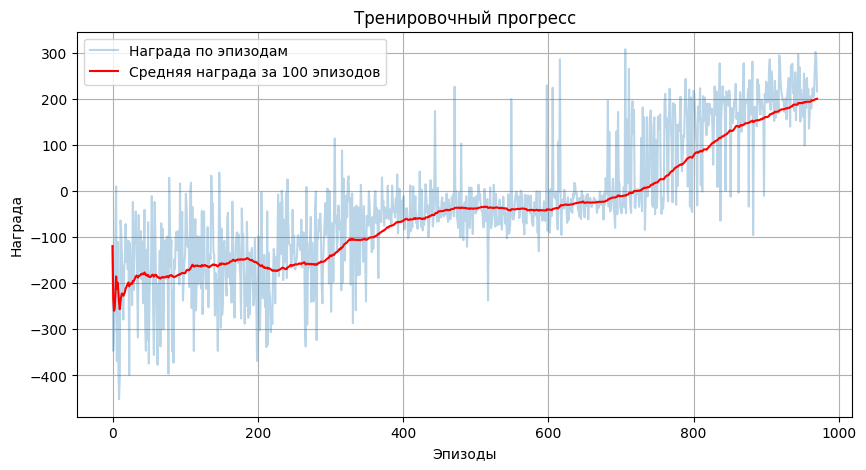

In [22]:
# Визуализация результатов
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(scores, alpha=0.3, label='Награда по эпизодам')
plt.plot(mean_scores, color='red', label='Средняя награда за 100 эпизодов')
plt.xlabel('Эпизоды')
plt.ylabel('Награда')
plt.title('Тренировочный прогресс')
plt.legend()
plt.grid(True)
plt.show()